In [4]:
import os
import random
from math import floor
test_dir = os.path.join("../data/test")
train_dir = os.path.join("../data/train")
validation_dir = os.path.join("../data/validation")

In [5]:
#Code used to seperate training data into seperate folders
#Does not need to be run since data is included in repo
def getCatsAndDogs(directory):
    cats = []
    dogs = []
    files = os.listdir(directory)
    # if file starts with c it is a cat file
    for file in files:
        if (file[0] == 'c'):
            cats.append(file)
        else:
            dogs.append(file)
    return cats,dogs

def makeCatsDogsDirs(trainDir):
    cats,dogs = getCatsAndDogs(trainDir)
    for cat,dog in zip(cats,dogs):
        curr = os.path.join(trainDir,cat)
        new = os.path.join(trainDir,"cats",cat)
        os.rename(curr,new)
        curr = os.path.join(trainDir,dog)
        new = os.path.join(trainDir,"dogs",dog)
        os.rename(curr,new)
        
def createValidationDirs(valDir,trainDir,valSplit):
    #retrieve file names for path construction
    filesCat = os.listdir(os.path.join(trainDir,"cats"))
    filesDog = os.listdir(os.path.join(trainDir,"dogs"))
    #get num files for validation set
    numCatVal = floor(len(filesCat) * valSplit)
    numDogVal = floor(len(filesDog) * valSplit)
    #Get random sample
    catSample = random.sample(range(0,len(filesCat)),numCatVal)
    dogSample = random.sample(range(0,len(filesDog)),numDogVal)
    #cosntruct indexes
    cats = [filesCat[i] for i in catSample]
    dogs = [filesDog[i] for i in dogSample]
    #make validation folders
    for cat,dog in zip(cats,dogs):
        curr = os.path.join(trainDir,"cats",cat)
        new = os.path.join(valDir,"cats",cat)
        os.rename(curr,new)
        curr = os.path.join(trainDir,"dogs",dog)
        new = os.path.join(valDir,"dogs",dog)
        os.rename(curr,new)
    

In [25]:
from keras.applications import VGG19

conv_base = VGG19(
    weights = 'imagenet',
    include_top = False,
    input_shape = ((150,150,3))
)
conv_base.trainable = False

In [26]:
conv_base.summary()
#Checking the final layer output so we can fit classifier

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [52]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [54]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
import numpy as np


train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=100,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=25,
    class_mode='binary')

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(), 
    metrics=['acc'])

def switchTrainability(layers):
    for layer in conv_base.layers:
        if layer.name in layers:
            layer.trainable = True
        else:
            layer.trainable = False

def fineTune(epoch):
    lr = 2e-5
    if epoch >= 14:
        lr = 2e-6
    if epoch >= 19:
        lr = 2e-7
    if epoch >= 24:
        conv_base.trainable = True
        switchTrainability([conv_base.layers[-2].name])
        model.compile(
                    loss='binary_crossentropy', 
                    optimizer=optimizers.RMSprop(), 
                    metrics=['acc']
        )
        print("Activating " + conv_base.layers[-2].name )
        lr = 2e-9
    if epoch >= 29:
        switchTrainability([conv_base.layers[-2].name,
                            conv_base.layers[-3].name])
        model.compile(
                    loss='binary_crossentropy', 
                    optimizer=optimizers.RMSprop(), 
                    metrics=['acc']
        )
        print("Activating " + conv_base.layers[-2].name + conv_base.layers[-3].name )
        lr = 2e-10
    print("Setting LR to "+ str(lr))
    return lr
#Num Samples = batch_size * steps_per_epoch
#Train   5000 = 100 * 50 -- Doing fourth the data to reduce run time
#Val     1250 = 25 * 50 -- Doing fourth as well

history = model.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50,
    callbacks=[LearningRateScheduler(fineTune)]
)


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Epoch 1/30
Setting LR to 2e-05
50/50 [==============================] - 847s 17s/step - loss: 0.3006 - acc: 0.8842 - val_loss: 0.2016 - val_acc: 0.9136
Epoch 2/30
Setting LR to 2e-05
50/50 [==============================] - 840s 17s/step - loss: 0.2214 - acc: 0.9086 - val_loss: 0.2152 - val_acc: 0.9048
Epoch 3/30
Setting LR to 2e-05
50/50 [==============================] - 840s 17s/step - loss: 0.2193 - acc: 0.9046 - val_loss: 0.1254 - val_acc: 0.9456
Epoch 4/30
Setting LR to 2e-05
50/50 [==============================] - 845s 17s/step - loss: 0.1981 - acc: 0.9170 - val_loss: 0.1425 - val_acc: 0.9416
Epoch 5/30
Setting LR to 2e-05
50/50 [==============================] - 846s 17s/step - loss: 0.2068 - acc: 0.9094 - val_loss: 0.1438 - val_acc: 0.9392
Epoch 6/30
Setting LR to 2e-05
50/50 [==============================] - 845s 17s/step - loss: 0.2063 - acc: 0.9098 - val_loss: 0.2022 - val_acc: 0.9104
Epo

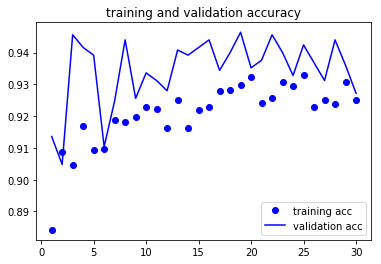

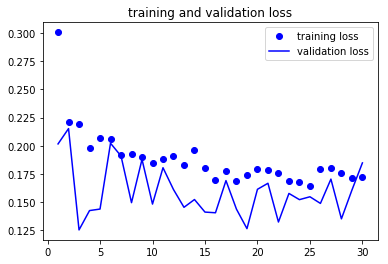

In [55]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

In [56]:
model.save("Fine_Tuning.h5")